In [2]:
import os
import umap
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import stats, pearsonr# Pearson cor

In [3]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing

In [4]:
datasets = dataprocessing.load_datasets()

In [5]:
key_BRCA = "BRCA"
tpm_dataBRCA = datasets[key_BRCA].data
genesBRCA = datasets[key_BRCA].genes
labelsBRCA = datasets[key_BRCA].labels
samplesBRCA = datasets[key_BRCA].samples
print(f"BRCA-data; genes nb: {genesBRCA.shape}, labels nb: {labelsBRCA.shape}, samples nb: {samplesBRCA.shape}")

key_LAML = "LAML"
tpm_dataLAML = datasets[key_LAML].data
genesLAML = datasets[key_LAML].genes
labelsLAML = datasets[key_LAML].labels
samplesLAML = datasets[key_LAML].samples
print(f"LAML-data; genes nb: {genesLAML.shape}, labels nb: {labelsLAML.shape}, samples nb: {samplesLAML.shape}")

key_TALL = "TALL"
tpm_dataTALL = datasets[key_TALL].data
genesTALL = datasets[key_TALL].genes
labelsTALL = datasets[key_TALL].labels
samplesTALL = datasets[key_TALL].samples
print(f"TALL-data; genes nb: {genesTALL.shape}, labels nb: {labelsTALL.shape}, samples nb: {samplesTALL.shape}")

key_TCGA = "TCGA"
tpm_dataTCGA = datasets[key_TCGA].data
genesTCGA = datasets[key_TCGA].genes
labelsTCGA = datasets[key_TCGA].labels
samplesTCGA = datasets[key_TCGA].samples
print(f"TCGA-data; genes nb: {genesTCGA.shape}, labels nb: {labelsTCGA.shape}, samples nb: {samplesTCGA.shape}")

BRCA-data; genes nb: (11802,), labels nb: (1023,), samples nb: (1023,)
LAML-data; genes nb: (19597,), labels nb: (300,), samples nb: (300,)
TALL-data; genes nb: (60660,), labels nb: (264,), samples nb: (264,)
TCGA-data; genes nb: (10346,), labels nb: (10346,), samples nb: (15165,)


### I. VISUALISATIONS DES DONNEES AVEC UMAP ###

#### 1.1 VISUALISATION DE BRCA AVEC UMAP ####

In [6]:
X_trainBRCA, X_testBRCA, Y_trainBRCA, Y_testBRCA = train_test_split(tpm_dataBRCA.T, labelsBRCA, test_size=0.2)

In [7]:
mapper = umap.UMAP(n_components=2, verbose=1, n_epochs=1000, n_neighbors=20, min_dist=0.5)
mapper.fit(X_trainBRCA) 
#mapper = umap.UMAP(min_dist=0.5, n_neighbors=20, n_epochs=1000, verbose=1).fit(X_trainBRCA)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sat Dec  9 12:33:09 2023 Construct fuzzy simplicial set
Sat Dec  9 12:33:11 2023 Finding Nearest Neighbors
Sat Dec  9 12:33:14 2023 Finished Nearest Neighbor Search
Sat Dec  9 12:33:17 2023 Construct embedding


Epochs completed:   7%| ██▊                                      70/1000 [00:02]

	completed  0  /  1000 epochs


Epochs completed:  14%| █████▋                                  145/1000 [00:02]

	completed  100  /  1000 epochs


Epochs completed:  36%| ██████████████▏                         363/1000 [00:02]

	completed  200  /  1000 epochs
	completed  300  /  1000 epochs


Epochs completed:  43%| ████████████████▋                       427/1000 [00:03]

	completed  400  /  1000 epochs


Epochs completed:  60%| ███████████████████████▎                598/1000 [00:03]

	completed  500  /  1000 epochs
	completed  600  /  1000 epochs


Epochs completed:  77%| █████████████████████████████▉          769/1000 [00:03]

	completed  700  /  1000 epochs
	completed  800  /  1000 epochs


Epochs completed: 100%| ██████████████████████████████████████ 1000/1000 [00:04]


	completed  900  /  1000 epochs
Sat Dec  9 12:33:22 2023 Finished embedding


UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)

In [8]:
X_tr_umapBRCA = mapper.transform(X_trainBRCA)
X_tst_umapBRCA = mapper.transform(X_testBRCA)

Epochs completed:  99%| ███████████████████████████████████████▌ 329/333 [00:02]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs


Epochs completed: 100%| ████████████████████████████████████████ 333/333 [00:02]

	completed  330  /  333 epochs


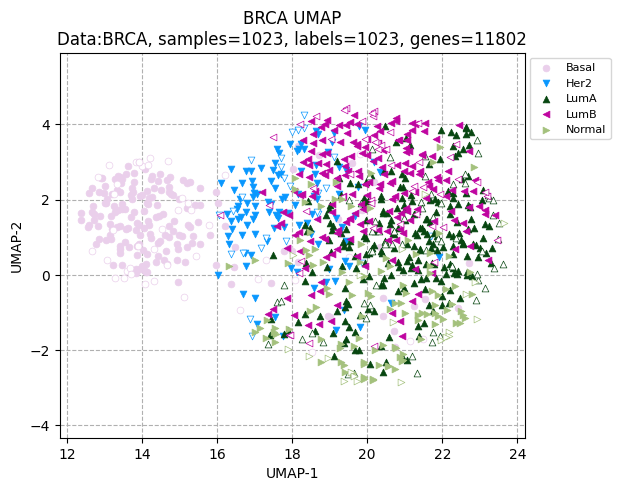

In [9]:
plotting.plot_umap(X_tr_umapBRCA, X_tst_umapBRCA, Y_trainBRCA, Y_testBRCA, labelsBRCA,key_BRCA, 1023, 1023, 11802, s=24) 

#### 1.2 VISUALISATION DE LAML AVEC UMAP ####

In [10]:
X_trainLAML, X_testLAML, Y_trainLAML, Y_testLAML = train_test_split(tpm_dataLAML.T, labelsLAML, test_size = 0.2)

In [11]:
mapper2 = umap.UMAP(verbose = 1,min_dist=0.5, n_components=2,
    n_neighbors =20, n_epochs = 1000).fit(X_trainLAML)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sat Dec  9 09:13:44 2023 Construct fuzzy simplicial set
Sat Dec  9 09:13:44 2023 Finding Nearest Neighbors
Sat Dec  9 09:13:44 2023 Finished Nearest Neighbor Search
Sat Dec  9 09:13:44 2023 Construct embedding


Epochs completed:  28%| ██████████▊                             278/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs


Epochs completed:  67%| ██████████████████████████▏             671/1000 [00:02]

	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs


Epochs completed: 100%| ██████████████████████████████████████ 1000/1000 [00:02]

	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Dec  9 09:13:47 2023 Finished embedding


In [12]:
X_tr_umapLAML = mapper2.transform(X_trainLAML)
X_tst_umapLAML = mapper2.transform(X_testLAML)

Epochs completed: 100%| ████████████████████████████████████████ 333/333 [00:02]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


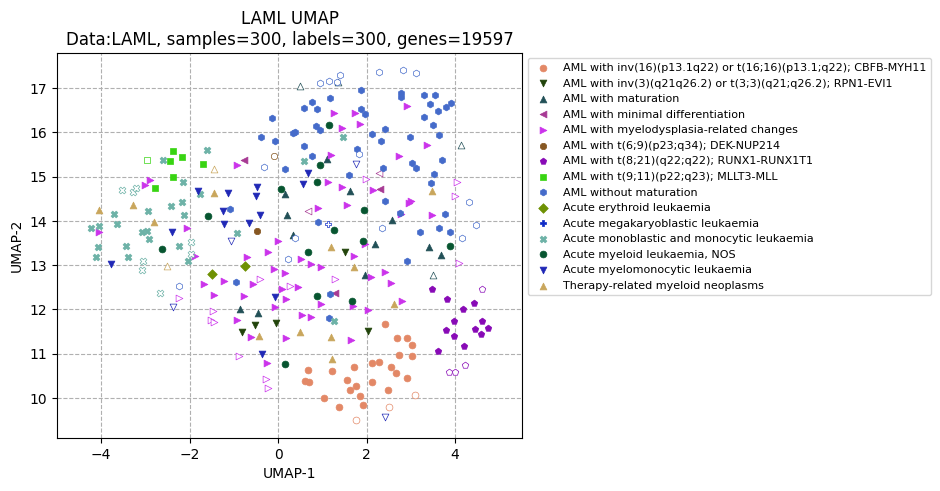

In [13]:
plotting.plot_umap(X_tr_umapLAML, X_tst_umapLAML, Y_trainLAML, Y_testLAML, labelsLAML, key_LAML,300, 300, 19597, s = 24)

#### 1.3 VISUALISATION DE TALL AVEC UMAP ####

In [14]:
X_trainTALL, X_testTALL, Y_trainTALL, Y_testTALL = train_test_split(tpm_dataTALL.T, labelsTALL, test_size = 0.2)

In [15]:
mapper3 = umap.UMAP(verbose = 1,min_dist=0.5, n_components=2,
    n_neighbors =20, n_epochs = 1000).fit(X_trainTALL)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Sat Dec  9 09:14:52 2023 Construct fuzzy simplicial set
Sat Dec  9 09:14:52 2023 Finding Nearest Neighbors
Sat Dec  9 09:14:52 2023 Finished Nearest Neighbor Search
Sat Dec  9 09:14:52 2023 Construct embedding


Epochs completed:  26%| █████████▉                              255/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs


Epochs completed:  54%| ████████████████████▉                   537/1000 [00:02]

	completed  400  /  1000 epochs
	completed  500  /  1000 epochs


Epochs completed:  77%| ██████████████████████████████▏         773/1000 [00:02]

	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs


Epochs completed: 100%| ██████████████████████████████████████ 1000/1000 [00:02]


	completed  900  /  1000 epochs
Sat Dec  9 09:14:55 2023 Finished embedding


In [16]:
X_tr_umapTALL = mapper3.transform(X_trainTALL)
X_tst_umapTALL = mapper3.transform(X_testTALL)

Epochs completed:  26%| ██████████▊                               88/333 [00:02]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs


Epochs completed: 100%| ████████████████████████████████████████ 333/333 [00:02]

	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


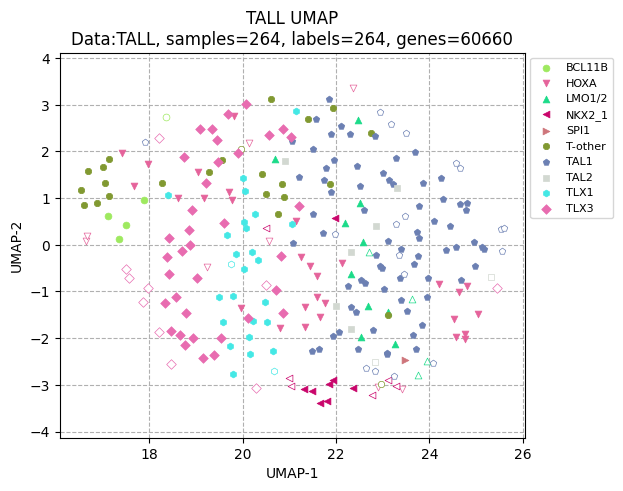

In [17]:
plotting.plot_umap(X_tr_umapTALL, X_tst_umapTALL, Y_trainTALL, Y_testTALL, labelsTALL, key_TALL, 264, 264, 60660, s = 24)

#### 1.4 VISUALISATION DE TCGA AVEC UMAP ####

In [18]:
X_trainTCGA, X_testTCGA, Y_trainTCGA, Y_testTCGA = train_test_split(tpm_dataTCGA.T, labelsTCGA, test_size = 0.2)

In [28]:
mapper4 = umap.UMAP(verbose = 1,min_dist=1., n_components=2,
    n_neighbors =100, n_epochs = 1000).fit(X_trainTCGA)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=100, verbose=1)
Sat Dec  9 09:31:50 2023 Construct fuzzy simplicial set
Sat Dec  9 09:31:50 2023 Finding Nearest Neighbors
Sat Dec  9 09:31:50 2023 Building RP forest with 10 trees
Sat Dec  9 09:31:52 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sat Dec  9 09:36:04 2023 Finished Nearest Neighbor Search
Sat Dec  9 09:36:05 2023 Construct embedding


Epochs completed:   1%| ▍                                        11/1000 [00:02]

	completed  0  /  1000 epochs


Epochs completed:  11%| ████▎                                   109/1000 [00:04]

	completed  100  /  1000 epochs


Epochs completed:  21%| ████████                                207/1000 [00:05]

	completed  200  /  1000 epochs


Epochs completed:  31%| ████████████▏                           312/1000 [00:07]

	completed  300  /  1000 epochs


Epochs completed:  41%| ███████████████▉                        408/1000 [00:09]

	completed  400  /  1000 epochs


Epochs completed:  51%| ███████████████████▉                    512/1000 [00:10]

	completed  500  /  1000 epochs


Epochs completed:  61%| ███████████████████████▋                607/1000 [00:12]

	completed  600  /  1000 epochs


Epochs completed:  71%| ███████████████████████████▌            707/1000 [00:14]

	completed  700  /  1000 epochs


Epochs completed:  81%| ███████████████████████████████▌        810/1000 [00:16]

	completed  800  /  1000 epochs


Epochs completed:  91%| ███████████████████████████████████▎    907/1000 [00:17]

	completed  900  /  1000 epochs


Epochs completed: 100%| ██████████████████████████████████████ 1000/1000 [00:19]


Sat Dec  9 09:36:26 2023 Finished embedding


In [29]:
X_tr_umapTCGA = mapper4.transform(X_trainTCGA)
X_tst_umapTCGA = mapper4.transform(X_testTCGA)

Sat Dec  9 09:36:37 2023 Worst tree score: 0.97825036
Sat Dec  9 09:36:37 2023 Mean tree score: 0.98092073
Sat Dec  9 09:36:37 2023 Best tree score: 0.98417110
Sat Dec  9 09:36:40 2023 Forward diversification reduced edges from 827600 to 63485
Sat Dec  9 09:36:41 2023 Reverse diversification reduced edges from 63485 to 63485
Sat Dec  9 09:36:41 2023 Degree pruning reduced edges from 78136 to 78136
Sat Dec  9 09:36:41 2023 Resorting data and graph based on tree order
Sat Dec  9 09:36:41 2023 Building and compiling search function


Epochs completed:   7%| ██▋                                       22/333 [00:02]

	completed  0  /  333 epochs
	completed  33  /  333 epochs


Epochs completed:  26%| ██████████▊                               88/333 [00:02]

	completed  66  /  333 epochs
	completed  99  /  333 epochs


Epochs completed:  47%| ██████████████████▌                      155/333 [00:03]

	completed  132  /  333 epochs
	completed  165  /  333 epochs


Epochs completed:  66%| ██████████████████████████▌              221/333 [00:03]

	completed  198  /  333 epochs


Epochs completed:  76%| ██████████████████████████████▍          253/333 [00:03]

	completed  231  /  333 epochs


Epochs completed:  86%| ██████████████████████████████████▏      285/333 [00:03]

	completed  264  /  333 epochs


Epochs completed:  95%| █████████████████████████████████████▉   316/333 [00:04]

	completed  297  /  333 epochs


Epochs completed: 100%| ████████████████████████████████████████ 333/333 [00:04]

	completed  330  /  333 epochs


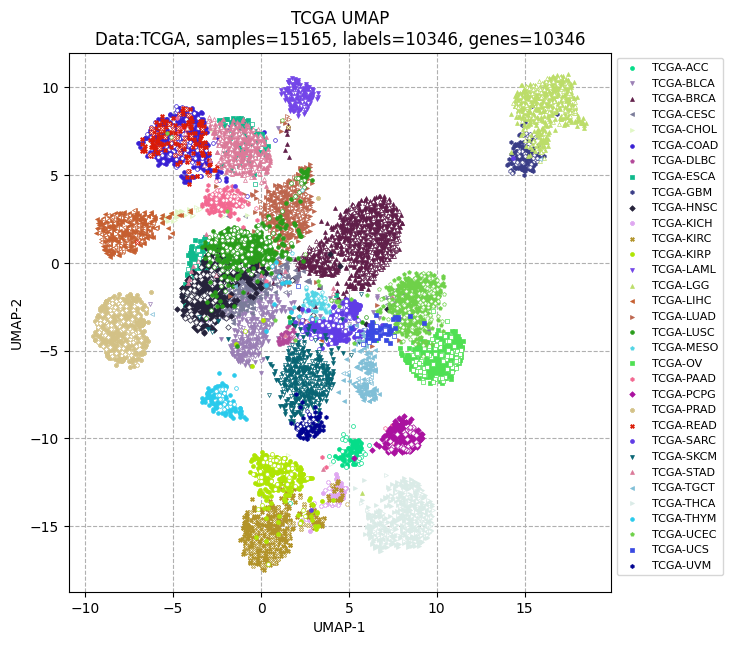

In [30]:
plotting.plot_umap(X_tr_umapTCGA, X_tst_umapTCGA, Y_trainTCGA, Y_testTCGA, labelsTCGA, key_TCGA, 10346, 15165, 10346, s = 8,figsize = (7,7))

### II. CREATION D'UN RESEAU DE NEURONES ARTIFICIEL POUR UN PROBLEME DE REGRESSION AVEC UN AUTO-ENCODEUR. ###
### EXEMPLE AVEC LES DONNES BRCA ###

#### II.1 Créez une fonction qui construit un modèle DNN selon la structure encoder => bottleneck => decoder ####

In [6]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labelsLAML))
X_train2, X_test2, Y_train2,  Y_test2 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(Y),test_size=0.2)
insize2 = X_train2.shape[1] ## some model setting variables
print(insize2)

19597


In [7]:
AE, encoder  = engines.auto_encoder(insize2, insize2, 2)
encoder(X_train2).shape

torch.Size([240, 2])

#### II.2 Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch ####
#### sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train. ####

In [8]:
mm2, trl2, tstl2, trc2, tstc2  = engines.train_auto_encoder(insize2, 125, X_train2, X_test2, nepochs = 1000, lr = 5 * 1e-4)

Loss 0 Train - loss : 1.194 - acc : 0.004 Test acc : 0.004
Loss 100 Train - loss : 0.045 - acc : 0.959 Test acc : 0.957
Loss 200 Train - loss : 0.044 - acc : 0.96 Test acc : 0.958
Loss 300 Train - loss : 0.044 - acc : 0.96 Test acc : 0.958
Loss 400 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958
Loss 500 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958
Loss 600 Train - loss : 0.044 - acc : 0.96 Test acc : 0.958
Loss 700 Train - loss : 0.044 - acc : 0.96 Test acc : 0.958
Loss 800 Train - loss : 0.046 - acc : 0.96 Test acc : 0.957
Loss 900 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958


#### II.3 Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire ####
#### la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs. ####

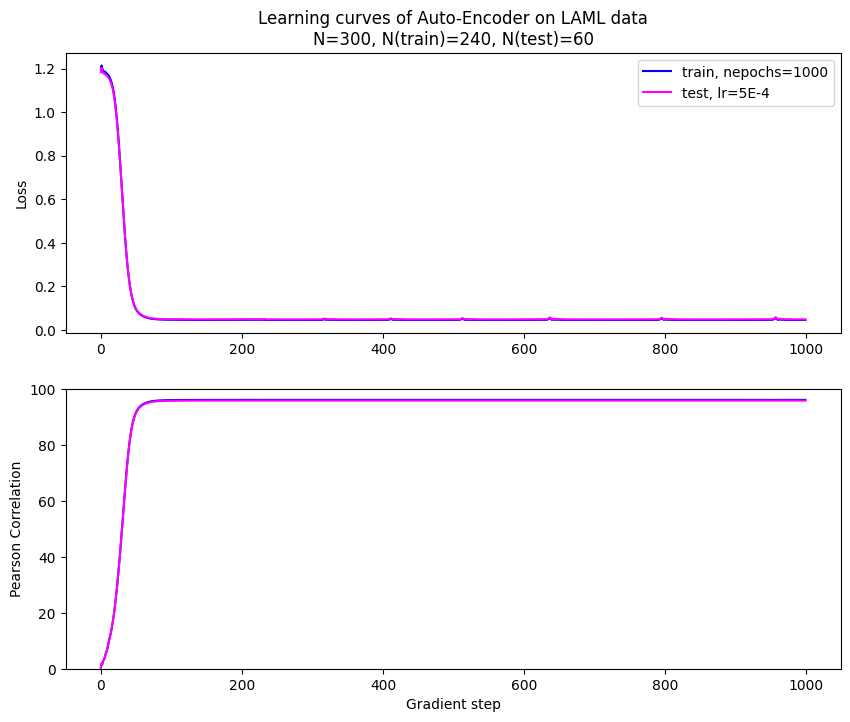

In [9]:
plotting.plot_learning_curves(trl2, tstl2, trc2, tstc2, tpm_dataLAML, X_train2, X_test2)

#### II.4 Faites la visualisation de la corrélation sur les données de test prédites et vraies. Rapportez votre ####
#### résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées. ####

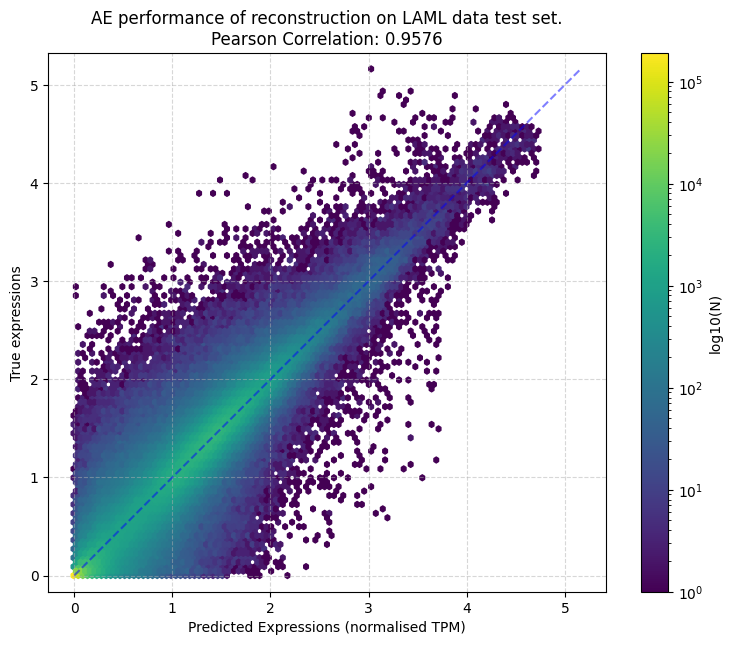

In [10]:
plotting.plot_ae_performance(mm2, X_test2, dataset = key_LAML)

### III. VARIATIONAL AUTO-ENCODERS (VAE) POUR UN GAIN DE PERFORMANCE DE RECONSTRUCTION DANS LES PROBLEMES DE REGRESSION. ###

In [7]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labelsLAML))
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(Y),test_size=0.2)
insize3 = X_train3.shape[1] ## some model setting variables

In [8]:
mm3 = engines.VariationalAutoencoder(insize3, 2)

In [9]:
VAE, trl3, tstl3, trc3, tstc3 = engines.train_variational_auto_encoder(insize3, 125, X_train3, X_test3, nepochs = 1000, printstep=100)

Loss 0 Train - loss : 1.298 - acc : -0.002 Test acc : -0.001
Loss 100 Train - loss : 0.046 - acc : 0.959 Test acc : 0.959
Loss 200 Train - loss : 0.045 - acc : 0.96 Test acc : 0.96
Loss 300 Train - loss : 0.045 - acc : 0.96 Test acc : 0.96
Loss 400 Train - loss : 0.038 - acc : 0.966 Test acc : 0.966
Loss 500 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 600 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 700 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 800 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 900 Train - loss : 0.037 - acc : 0.967 Test acc : 0.967
Loss 999 Train - loss : 0.037 - acc : 0.967 Test acc : 0.967


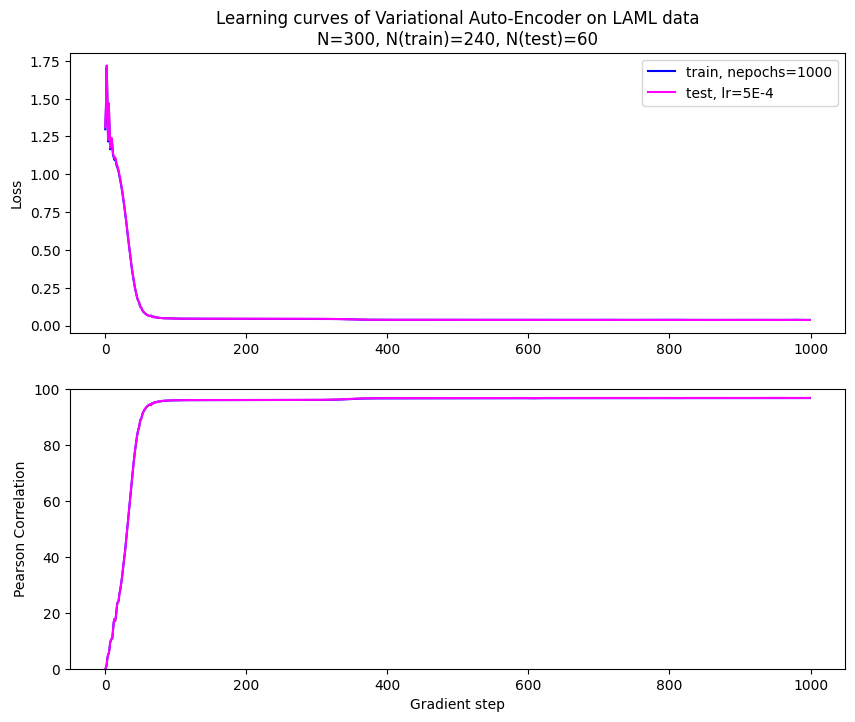

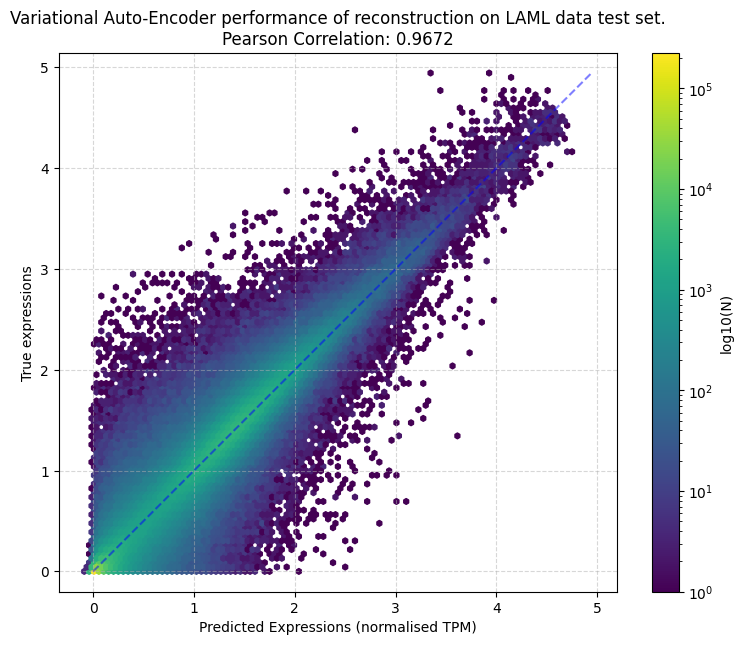

In [10]:
plotting.plot_learning_curves(trl3, tstl3, trc3, tstc3, tpm_dataLAML, X_train3, X_test3)
plotting.plot_ae_performance(VAE, X_test3, modeltype ="VAE", dataset = key_LAML)

### IV. UMAP SUPERVISE ###

In [39]:
lblenc = LabelEncoder()
lblenc.fit(labelsLAML)
Y4 = lblenc.transform(labelsLAML)
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(tpm_dataLAML.T, Y4, test_size = 0.2)
mapper4 = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =10, n_epochs = 1000).fit(X_train4,  y = Y_train4)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=10, verbose=1)
Sat Dec  9 20:57:36 2023 Construct fuzzy simplicial set
Sat Dec  9 20:57:36 2023 Finding Nearest Neighbors
Sat Dec  9 20:57:36 2023 Finished Nearest Neighbor Search
Sat Dec  9 20:57:36 2023 Construct embedding


Epochs completed:  44%| ████████████████▉                       435/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs


Epochs completed: 100%| ██████████████████████████████████████ 1000/1000 [00:02]


	completed  900  /  1000 epochs
Sat Dec  9 20:57:38 2023 Finished embedding


In [40]:
X_tr_umap4 = mapper4.transform(X_train4)
X_tst_umap4 = mapper4.transform(X_test4)

Epochs completed: 100%| ████████████████████████████████████████ 333/333 [00:01]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


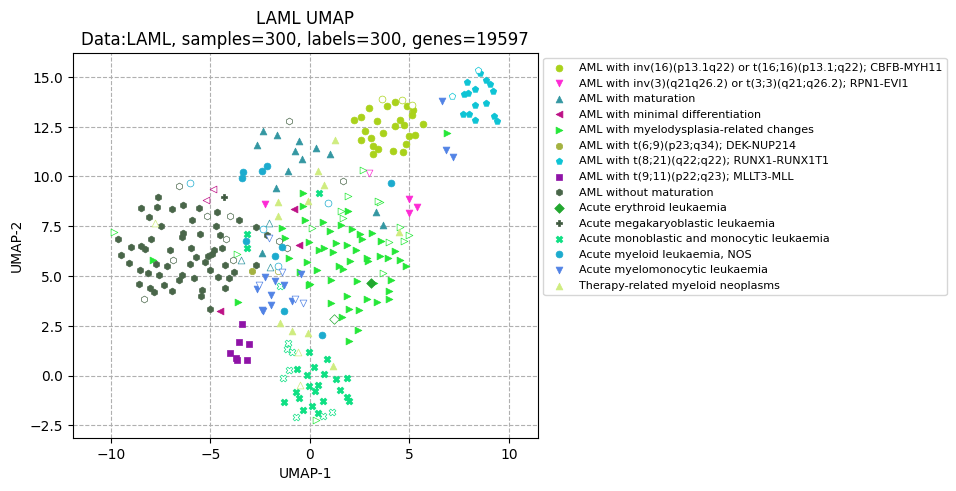

In [41]:
plotting.plot_umap(X_tr_umap4, X_tst_umap4, lblenc.inverse_transform(Y_train4), lblenc.inverse_transform(Y_test4), labelsLAML, key_LAML, 300, 300, 19597, s = 24)

## PROJECT ONE : Régression et classification, quelle méthode utiliser et pourquoi? ##

### A. Testez les modèles suivants SVM, RF, Logistic (RCF), DNN pour la classification des sous-types moléculaires de BRCA, LAML, TALL. ###

#### A.1. SVM and BRCA data ####

In [6]:
acc_svm_brca = engines.SVM_algo(tpm_dataBRCA, labelsBRCA, max_iter = 1000)

In [7]:
print(acc_svm_brca)

[82.93, 82.44, 83.41, 80.0, 81.46, 79.02, 83.41, 81.95, 82.93, 81.95]


#### A.2 SVM and LAML data ####

In [12]:
acc_svm_LAML = engines.SVM_algo(tpm_dataLAML, labelsLAML, max_iter = 10000)

/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase

In [13]:
print(acc_svm_LAML)

[65.0, 61.67, 65.0, 63.33, 70.0, 61.67, 68.33, 58.330000000000005, 46.67, 63.33]


#### A.3 SVM and TALL data ####

In [14]:
acc_svm_TALL = engines.SVM_algo(tpm_dataTALL, labelsTALL, max_iter = 10000)

/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase

In [15]:
print(acc_svm_TALL)

[84.91, 79.25, 79.25, 77.36, 81.13, 86.79, 77.36, 81.13, 75.47, 84.91]


#### A.4 SVM and TCGA data ####

In [31]:
acc_svm_TCGA = engines.SVM_algo(tpm_dataTCGA, labelsTCGA, max_iter = 1000)

/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mac/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase

In [32]:
print(acc_svm_TCGA)

[97.1, 96.76, 97.2, 96.86, 96.67, 96.96000000000001, 97.0, 96.86, 97.25, 96.43]


#### SVM AND THE FOUR DATASETS ####

Text(0, 0.5, 'Performance values (%)')

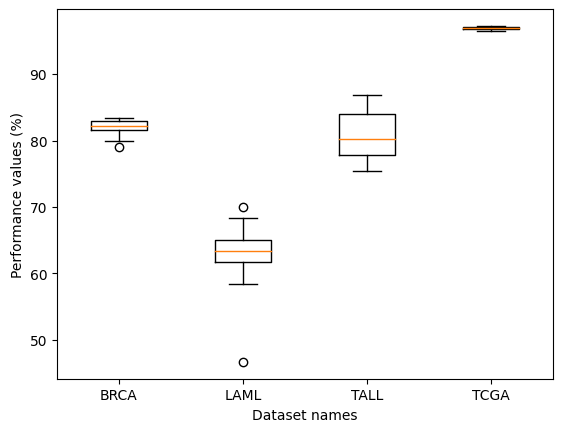

In [34]:
my_dict = {'BRCA': [82.93, 82.44, 83.41, 80.0, 81.46, 79.02, 83.41, 81.95, 82.93, 81.95], 
           'LAML': [65.0, 61.67, 65.0, 63.33, 70.0, 61.67, 68.33, 58.33, 46.67, 63.33],
           'TALL': [84.91, 79.25, 79.25, 77.36, 81.13, 86.79, 77.36, 81.13, 75.47, 84.91],
           'TCGA': [97.1, 96.76, 97.2, 96.86, 96.67, 96.96, 97.0, 96.86, 97.25, 96.43]}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

#### A.5 Random Forest and BRCA data ####

In [8]:
acc_rf_BRCA = engines.RandomF_algo(tpm_dataBRCA, labelsBRCA)

In [9]:
print(acc_rf_BRCA)

[80.0, 83.89999999999999, 77.07000000000001, 80.49, 80.0, 79.02, 80.49, 82.44, 82.93, 84.39]


#### A.6 Random Forest and LAML data ####

In [10]:
acc_rf_LAML = engines.RandomF_algo(tpm_dataLAML, labelsLAML)

In [11]:
print(acc_rf_LAML)

[63.33, 63.33, 66.67, 60.0, 70.0, 63.33, 51.67, 61.67, 61.67, 53.33]


#### A.7 Random Forest and TALL data ####

In [12]:
acc_rf_TALL = engines.RandomF_algo(tpm_dataTALL, labelsTALL)

In [13]:
print(acc_rf_TALL)

[83.02000000000001, 77.36, 84.91, 77.36, 66.03999999999999, 79.25, 81.13, 71.7, 81.13, 75.47]


#### A.8 Random Forest and TCGA data ####

In [35]:
acc_rf_TCGA = engines.RandomF_algo(tpm_dataTCGA, labelsTCGA)

In [36]:
print(acc_rf_TCGA)

[93.62, 92.80000000000001, 92.9, 93.53, 93.72, 94.44, 93.67, 93.96, 94.11, 94.15]


#### RANDOM FOREST AND THE FOUR DATASETS ####

Text(0, 0.5, 'Performance values (%)')

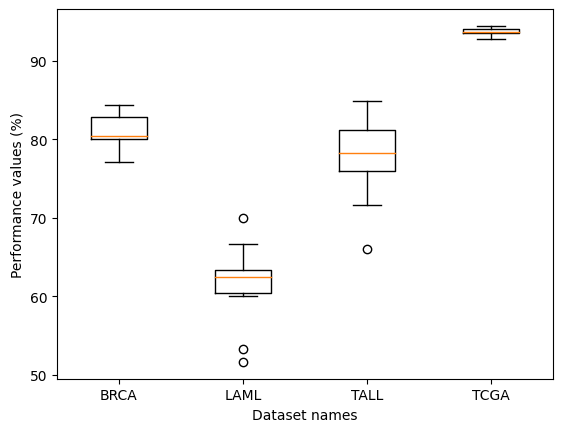

In [37]:
my_dict2 = {'BRCA': [80.0, 83.8999999, 77.07, 80.49, 80.0, 79.02, 80.49, 82.44, 82.93, 84.39], 
           'LAML': [63.33, 63.33, 66.67, 60.0, 70.0, 63.33, 51.67, 61.67, 61.67, 53.33],
           'TALL': [83.02, 77.36, 84.91, 77.36, 66.0399, 79.25, 81.13, 71.7, 81.13, 75.47],
           'TCGA': [93.62, 92.81, 92.9, 93.53, 93.72, 94.44, 93.67, 93.96, 94.11, 94.15]}

fig, ax = plt.subplots()
ax.boxplot(my_dict2.values())
ax.set_xticklabels(my_dict2.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

#### A.9 RidgeClassifier and BRCA data ####

In [15]:
acc_rcl_BRCA = engines.RidgeC_algo(tpm_dataBRCA, labelsBRCA, 100)

In [16]:
print(acc_rcl_BRCA)

[80.0, 79.02, 76.59, 82.44, 79.02, 72.2, 75.61, 82.44, 80.97999999999999, 78.53999999999999]


#### A.10 RidgeClassifier and LAML data ####

In [17]:
acc_rcl_LAML = engines.RidgeC_algo(tpm_dataLAML, labelsLAML, 100)

In [18]:
print(acc_rcl_LAML)

[56.67, 55.00000000000001, 56.67, 55.00000000000001, 51.67, 56.67, 51.67, 68.33, 60.0, 73.33]


#### A.11 RidgeClassifier and TALL data ####

In [19]:
acc_rcl_TALL = engines.RidgeC_algo(tpm_dataTALL, labelsTALL, 100)

In [21]:
print(acc_rcl_TALL)

[84.91, 77.36, 83.02000000000001, 90.57, 88.68, 81.13, 81.13, 86.79, 84.91, 83.02000000000001]


#### A.12 RidgeClassifier and TCGA data ####

In [38]:
acc_rcl_TCGA = engines.RidgeC_algo(tpm_dataTCGA, labelsTCGA, 100)

In [39]:
print(acc_rcl_TCGA)

[97.05, 96.52, 95.94, 96.71, 97.0, 97.05, 96.33, 96.71, 96.61999999999999, 96.38]


#### RIDGECLASSIFIER AND THE FOUR DATASETS ####

Text(0, 0.5, 'Performance values (%)')

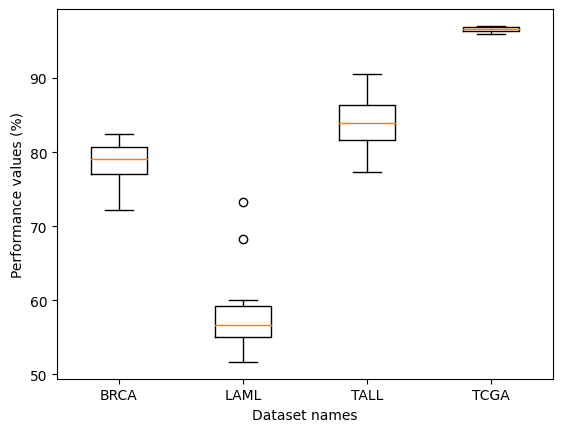

In [40]:
my_dict3 = {'BRCA': [80.0, 79.02, 76.59, 82.44, 79.02, 72.2, 75.61, 82.44, 80.97999999999999, 78.53999999999999], 
           'LAML': [56.67, 55.00000000000001, 56.67, 55.00000000000001, 51.67, 56.67, 51.67, 68.33, 60.0, 73.33],
           'TALL': [84.91, 77.36, 83.02000000000001, 90.57, 88.68, 81.13, 81.13, 86.79, 84.91, 83.02000000000001],
           'TCGA': [97.05, 96.52, 95.94, 96.71, 97.0, 97.05, 96.33, 96.71, 96.61999999999999, 96.38]}

fig, ax = plt.subplots()
ax.boxplot(my_dict3.values())
ax.set_xticklabels(my_dict3.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

#### A.13 DNN and BRCA data ####

In [24]:
acc_DNN_BRCA,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y = lblbin.fit_transform(labelsBRCA)
    X_train23, X_test23, Y_train23, Y_test23 = train_test_split(torch.Tensor(tpm_dataBRCA.T), torch.Tensor(Y), test_size= 0.2)
    mmB, tr_losses, tst_losses, tr_accs, tst_accs = engines.trainDNN(X_train23, Y_train23, X_test23, Y_test23, nepochs = 1000, printstep = 1000)
    acc_DNN_BRCA.append(np.mean(np.array(mmB(X_test23).max(1).indices == Y_test23.max(1).indices, dtype= int)))
    
#print(f"Accuracy on test set (n = {X_test23.shape[0]}): {round(np.mean( dnn_clf_accs) * 100, 4)} +/- {round(np.std(dnn_clf_accs) * 100,4)}%"

0Loss Train:1.6185 - Acc:0.1271 - Test:1.6228-Acc: 0.1415 
999 Loss Train: 0.0007 - Acc: 1.0 - Test : 0.5925 - Acc: 0.8293 
0Loss Train:1.606 - Acc:0.2421 - Test:1.6093-Acc: 0.2146 
999 Loss Train: 0.0008 - Acc: 1.0 - Test : 0.5363 - Acc: 0.8439 
0Loss Train:1.6024 - Acc:0.2249 - Test:1.5985-Acc: 0.2098 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 0.4933 - Acc: 0.8585 
0Loss Train:1.6316 - Acc:0.1296 - Test:1.6327-Acc: 0.1366 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 0.8119 - Acc: 0.8146 
0Loss Train:1.6163 - Acc:0.1357 - Test:1.6166-Acc: 0.1073 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 0.7764 - Acc: 0.8 
0Loss Train:1.6017 - Acc:0.2885 - Test:1.6008-Acc: 0.2878 
999 Loss Train: 0.0009 - Acc: 1.0 - Test : 0.7573 - Acc: 0.7561 
0Loss Train:1.6165 - Acc:0.1308 - Test:1.6111-Acc: 0.161 
999 Loss Train: 0.0008 - Acc: 1.0 - Test : 0.6288 - Acc: 0.8244 
0Loss Train:1.6231 - Acc:0.1381 - Test:1.6311-Acc: 0.1024 
999 Loss Train: 0.0009 - Acc: 1.0 - Test : 0.4992 - Acc: 0.8293 
0Loss Train:1

In [25]:
print(acc_DNN_BRCA)

[0.8292682926829268, 0.8439024390243902, 0.8585365853658536, 0.8146341463414634, 0.8, 0.7560975609756098, 0.824390243902439, 0.8292682926829268, 0.8, 0.8439024390243902]


#### A.14 DNN and LAML data ####

In [26]:
acc_DNN_LAML, n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y2 = lblbin.fit_transform(labelsLAML)
    X_train2, X_test2, Y_train2, Y_test2 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(Y2), test_size= 0.2)
    mmC, tr_losses, tst_losses, tr_accs, tst_accs = engines.train(X_train2, Y_train2, X_test2, Y_test2, nepochs = 1000, printstep = 1000)
    acc_DNN_LAML.append(np.mean(np.array(mmC(X_test2).max(1).indices == Y_test2.max(1).indices, dtype= int)))
    

0Loss Train:2.715 - Acc:0.0083 - Test:2.7337-Acc: 0.0 
999 Loss Train: 0.0024 - Acc: 1.0 - Test : 3.1864 - Acc: 0.5667 
0Loss Train:2.7232 - Acc:0.0208 - Test:2.7194-Acc: 0.0333 
999 Loss Train: 0.0026 - Acc: 1.0 - Test : 2.6818 - Acc: 0.6 
0Loss Train:2.6844 - Acc:0.025 - Test:2.6819-Acc: 0.0333 
999 Loss Train: 0.0021 - Acc: 1.0 - Test : 1.7191 - Acc: 0.6167 
0Loss Train:2.7202 - Acc:0.1083 - Test:2.7287-Acc: 0.0333 
999 Loss Train: 0.0036 - Acc: 1.0 - Test : 2.8089 - Acc: 0.5667 
0Loss Train:2.6837 - Acc:0.2458 - Test:2.6939-Acc: 0.1833 
999 Loss Train: 0.0031 - Acc: 1.0 - Test : 2.4426 - Acc: 0.5333 
0Loss Train:2.7071 - Acc:0.05 - Test:2.7014-Acc: 0.0833 
999 Loss Train: 0.003 - Acc: 1.0 - Test : 3.3473 - Acc: 0.45 
0Loss Train:2.6963 - Acc:0.2292 - Test:2.7033-Acc: 0.2 
999 Loss Train: 0.0037 - Acc: 1.0 - Test : 2.3329 - Acc: 0.6333 
0Loss Train:2.7002 - Acc:0.0125 - Test:2.6979-Acc: 0.0 
999 Loss Train: 0.0033 - Acc: 1.0 - Test : 2.2103 - Acc: 0.6333 
0Loss Train:2.7417 - Acc:0.

In [27]:
print(acc_DNN_LAML)

[0.5666666666666667, 0.6, 0.6166666666666667, 0.5666666666666667, 0.5333333333333333, 0.45, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6333333333333333]


#### A.15 DNN and TALL data ####

In [28]:
acc_DNN_TALL,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y3 = lblbin.fit_transform(labelsTALL)
    X_train3, X_test3, Y_train3, Y_test3 = train_test_split(torch.Tensor(tpm_dataTALL.T), torch.Tensor(Y3), test_size= 0.2)
    mmD, tr_losses, tst_losses, tr_accs, tst_accs = engines.train(X_train3, Y_train3, X_test3, Y_test3, nepochs = 1000, printstep = 1000)
    acc_DNN_TALL.append(np.mean(np.array(mmD(X_test3).max(1).indices == Y_test3.max(1).indices, dtype= int)))
    

0Loss Train:2.3121 - Acc:0.1517 - Test:2.3015-Acc: 0.2642 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 1.3018 - Acc: 0.717 
0Loss Train:2.2946 - Acc:0.0474 - Test:2.2843-Acc: 0.0755 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 0.754 - Acc: 0.7736 
0Loss Train:2.3157 - Acc:0.1327 - Test:2.2987-Acc: 0.1698 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 1.1798 - Acc: 0.7736 
0Loss Train:2.2944 - Acc:0.019 - Test:2.316-Acc: 0.0189 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 2.0593 - Acc: 0.6604 
0Loss Train:2.2851 - Acc:0.1327 - Test:2.2762-Acc: 0.1698 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 0.9137 - Acc: 0.7925 
0Loss Train:2.3025 - Acc:0.1801 - Test:2.2949-Acc: 0.1509 
999 Loss Train: 0.0007 - Acc: 1.0 - Test : 1.2247 - Acc: 0.8113 
0Loss Train:2.2936 - Acc:0.1422 - Test:2.2948-Acc: 0.1321 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 1.0415 - Acc: 0.7547 
0Loss Train:2.3385 - Acc:0.0995 - Test:2.3281-Acc: 0.0943 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 1.3675 - Acc: 0.6981 
0Loss Train:

In [29]:
print(acc_DNN_TALL)

[0.7169811320754716, 0.7735849056603774, 0.7735849056603774, 0.660377358490566, 0.7924528301886793, 0.8113207547169812, 0.7547169811320755, 0.6981132075471698, 0.7924528301886793, 0.8679245283018868]


#### A.16 DNN and TCGA data ####

In [41]:
acc_DNN_TCGA,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y4 = lblbin.fit_transform(labelsTCGA)
    X_train4, X_test4, Y_train4, Y_test4 = train_test_split(torch.Tensor(tpm_dataTCGA.T), torch.Tensor(Y4), test_size= 0.2)
    mmE, tr_losses, tst_losses, tr_accs, tst_accs = engines.train(X_train4, Y_train4, X_test4, Y_test4, nepochs = 1000, printstep = 1000)
    acc_DNN_TCGA.append(np.mean(np.array(mmE(X_test4).max(1).indices == Y_test4.max(1).indices, dtype= int)))
    

0Loss Train:3.4952 - Acc:0.0489 - Test:3.4956-Acc: 0.0444 
999 Loss Train: 0.0085 - Acc: 0.9998 - Test : 0.1074 - Acc: 0.9662 
0Loss Train:3.504 - Acc:0.0296 - Test:3.5046-Acc: 0.0246 
999 Loss Train: 0.0079 - Acc: 0.9998 - Test : 0.1654 - Acc: 0.9517 
0Loss Train:3.4986 - Acc:0.0288 - Test:3.5022-Acc: 0.0251 
999 Loss Train: 0.0059 - Acc: 0.9999 - Test : 0.152 - Acc: 0.9565 
0Loss Train:3.4999 - Acc:0.0116 - Test:3.5014-Acc: 0.0116 
999 Loss Train: 0.0067 - Acc: 0.9998 - Test : 0.1216 - Acc: 0.9628 
0Loss Train:3.4958 - Acc:0.0521 - Test:3.4978-Acc: 0.0435 
999 Loss Train: 0.0063 - Acc: 0.9999 - Test : 0.1496 - Acc: 0.9594 
0Loss Train:3.5237 - Acc:0.0062 - Test:3.5246-Acc: 0.0058 
999 Loss Train: 0.0101 - Acc: 0.9996 - Test : 0.1443 - Acc: 0.9522 
0Loss Train:3.5042 - Acc:0.0262 - Test:3.5021-Acc: 0.0232 
999 Loss Train: 0.0094 - Acc: 0.9996 - Test : 0.1454 - Acc: 0.956 
0Loss Train:3.4938 - Acc:0.0453 - Test:3.4945-Acc: 0.0391 
999 Loss Train: 0.0079 - Acc: 0.9996 - Test : 0.146 - A

In [42]:
print(acc_DNN_TCGA)

[0.966183574879227, 0.9521739130434783, 0.9565217391304348, 0.9628019323671497, 0.9594202898550724, 0.9521739130434783, 0.9565217391304348, 0.9594202898550724, 0.9536231884057971, 0.9502415458937198]


#### DNN AND THE FOUR DATASETS ####

Text(0, 0.5, 'Performance values (%)')

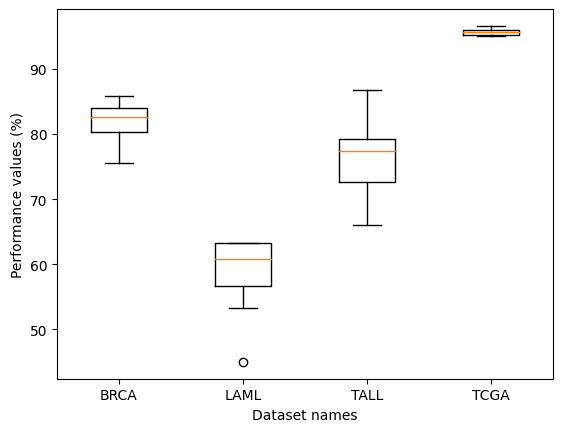

In [43]:
my_dict4 = {'BRCA': [82.9268, 84.3902, 85.8536, 81.463, 80.0, 75.6097, 82.439, 82.9268, 80.0, 84.39], 
           'LAML': [56.6667, 60.0, 61.667, 56.6667, 53.333, 45.0, 63.333, 63.333, 63.33, 63.33],
           'TALL': [71.698, 77.35849, 77.35849, 66.0377, 79.24528, 81.132, 75.4716, 69.8113, 79.24528, 86.79245],
           'TCGA': [96.618, 95.217, 95.652, 96.280, 95.942, 95.217, 95.65217, 95.942, 95.362, 95.02415]
}

fig, ax = plt.subplots()
ax.boxplot(my_dict4.values())
ax.set_xticklabels(my_dict4.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

### B. Testez les modèles suivants Auto-Encoders, VAE, Random-Forest, SVM et la regression lineaire, pour la prediction de l expression de tous les genes des jeux de donnees. ###

### B.1 DNNLinear ###

In [6]:
acc_DNNLinear_BRCA,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    YL1 = lblbin.fit_transform(labelsBRCA)
    X_trainL1, X_testL1, Y_trainL1, Y_testL1 = train_test_split(torch.Tensor(tpm_dataBRCA.T), torch.Tensor(YL1), test_size= 0.2)
    mmL1, tr_losses, tst_losses, tr_accs, tst_accs = engines.trainDNNLinear(X_trainL1, Y_trainL1, X_testL1, Y_testL1, nepochs = 1000, printstep = 1000)
    acc_DNNLinear_BRCA.append(np.mean(np.array(mmL1(X_testL1).max(1).indices == Y_testL1.max(1).indices, dtype= int)))
    

0Loss Train:1.5976 - Acc:0.2812 - Test:1.5958-Acc: 0.3122 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.8168 - Acc: 0.8098 
0Loss Train:1.6219 - Acc:0.11 - Test:1.6244-Acc: 0.1805 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.6464 - Acc: 0.839 
0Loss Train:1.6046 - Acc:0.2054 - Test:1.6093-Acc: 0.1902 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.6165 - Acc: 0.8244 
0Loss Train:1.6336 - Acc:0.132 - Test:1.633-Acc: 0.1268 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.4944 - Acc: 0.8585 
0Loss Train:1.5943 - Acc:0.2873 - Test:1.5981-Acc: 0.2976 
999 Loss Train: 0.0003 - Acc: 1.0 - Test : 0.5332 - Acc: 0.8537 
0Loss Train:1.6219 - Acc:0.2017 - Test:1.6233-Acc: 0.1951 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.8933 - Acc: 0.7951 
0Loss Train:1.6208 - Acc:0.0954 - Test:1.6183-Acc: 0.122 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.5213 - Acc: 0.8683 
0Loss Train:1.6235 - Acc:0.1247 - Test:1.6177-Acc: 0.1463 
999 Loss Train: 0.0004 - Acc: 1.0 - Test : 0.4695 - Acc: 0.8537 
0Loss Train:1.

In [7]:
print(acc_DNNLinear_BRCA)

[0.8097560975609757, 0.8390243902439024, 0.824390243902439, 0.8585365853658536, 0.8536585365853658, 0.7951219512195122, 0.8682926829268293, 0.8536585365853658, 0.8341463414634146, 0.7951219512195122]


In [8]:
acc_DNNLinear_LAML,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    YL2 = lblbin.fit_transform(labelsLAML)
    X_trainL2, X_testL2, Y_trainL2, Y_testL2 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(YL2), test_size= 0.2)
    mmL2, tr_losses, tst_losses, tr_accs, tst_accs = engines.trainDNNLinear(X_trainL2, Y_trainL2, X_testL2, Y_testL2, nepochs = 1000, printstep = 1000)
    acc_DNNLinear_LAML.append(np.mean(np.array(mmL2(X_testL2).max(1).indices == Y_testL2.max(1).indices, dtype= int)))
    

0Loss Train:2.7211 - Acc:0.0083 - Test:2.7393-Acc: 0.0 
999 Loss Train: 0.001 - Acc: 1.0 - Test : 2.9055 - Acc: 0.5167 
0Loss Train:2.6819 - Acc:0.175 - Test:2.6825-Acc: 0.15 
999 Loss Train: 0.0012 - Acc: 1.0 - Test : 3.2407 - Acc: 0.4667 
0Loss Train:2.6878 - Acc:0.1 - Test:2.7018-Acc: 0.05 
999 Loss Train: 0.0011 - Acc: 1.0 - Test : 2.7392 - Acc: 0.6167 
0Loss Train:2.6921 - Acc:0.0625 - Test:2.6703-Acc: 0.0667 
999 Loss Train: 0.0013 - Acc: 1.0 - Test : 2.5374 - Acc: 0.5 
0Loss Train:2.7578 - Acc:0.025 - Test:2.7531-Acc: 0.0333 
999 Loss Train: 0.0012 - Acc: 1.0 - Test : 1.8147 - Acc: 0.6167 
0Loss Train:2.7728 - Acc:0.0333 - Test:2.7678-Acc: 0.1 
999 Loss Train: 0.0011 - Acc: 1.0 - Test : 2.2224 - Acc: 0.6167 
0Loss Train:2.7339 - Acc:0.0083 - Test:2.7175-Acc: 0.0167 
999 Loss Train: 0.0013 - Acc: 1.0 - Test : 1.9216 - Acc: 0.65 
0Loss Train:2.7222 - Acc:0.0542 - Test:2.7246-Acc: 0.0167 
999 Loss Train: 0.0012 - Acc: 1.0 - Test : 1.6547 - Acc: 0.65 
0Loss Train:2.7391 - Acc:0.05 -

In [9]:
print(acc_DNNLinear_LAML)

[0.5166666666666667, 0.4666666666666667, 0.6166666666666667, 0.5, 0.6166666666666667, 0.6166666666666667, 0.65, 0.65, 0.5166666666666667, 0.5666666666666667]


In [6]:
acc_DNNLinear_TALL,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    YL3 = lblbin.fit_transform(labelsTALL)
    X_trainL3, X_testL3, Y_trainL3, Y_testL3 = train_test_split(torch.Tensor(tpm_dataTALL.T), torch.Tensor(YL3), test_size= 0.2)
    mmL3, tr_losses, tst_losses, tr_accs, tst_accs = engines.trainDNNLinear(X_trainL3, Y_trainL3, X_testL3, Y_testL3, nepochs = 1000, printstep = 1000)
    acc_DNNLinear_TALL.append(np.mean(np.array(mmL3(X_testL3).max(1).indices == Y_testL3.max(1).indices, dtype= int)))
    

0Loss Train:2.2652 - Acc:0.1422 - Test:2.2298-Acc: 0.1321 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 0.7048 - Acc: 0.8679 
0Loss Train:2.3196 - Acc:0.0237 - Test:2.3069-Acc: 0.0189 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 0.9 - Acc: 0.8113 
0Loss Train:2.2464 - Acc:0.3412 - Test:2.2343-Acc: 0.3396 
999 Loss Train: 0.0006 - Acc: 1.0 - Test : 1.1064 - Acc: 0.7736 
0Loss Train:2.3322 - Acc:0.0758 - Test:2.3384-Acc: 0.0566 
999 Loss Train: 0.0005 - Acc: 1.0 - Test : 0.6552 - Acc: 0.8679 
0Loss Train:2.3731 - Acc:0.0569 - Test:2.3882-Acc: 0.0566 
999 Loss Train: 0.0007 - Acc: 1.0 - Test : 0.7204 - Acc: 0.7925 
0Loss Train:2.2868 - Acc:0.0047 - Test:2.3072-Acc: 0.0 
999 Loss Train: 0.0008 - Acc: 1.0 - Test : 0.9179 - Acc: 0.7925 
0Loss Train:2.4086 - Acc:0.0047 - Test:2.3573-Acc: 0.0189 
999 Loss Train: 0.0008 - Acc: 1.0 - Test : 1.4996 - Acc: 0.6792 
0Loss Train:2.3072 - Acc:0.0521 - Test:2.2857-Acc: 0.0566 
999 Loss Train: 0.0007 - Acc: 1.0 - Test : 0.7285 - Acc: 0.8491 
0Loss Train:2.

In [7]:
print(acc_DNNLinear_TALL)

[0.8679245283018868, 0.8113207547169812, 0.7735849056603774, 0.8679245283018868, 0.7924528301886793, 0.7924528301886793, 0.6792452830188679, 0.8490566037735849, 0.7169811320754716, 0.8301886792452831]


In [8]:
acc_DNNLinear_TCGA,n_rep = [], 10 
for i in range(n_rep):
    lblbin = LabelBinarizer()
    YL4 = lblbin.fit_transform(labelsTCGA)
    X_trainL4, X_testL4, Y_trainL4, Y_testL4 = train_test_split(torch.Tensor(tpm_dataTCGA.T), torch.Tensor(YL4), test_size= 0.2)
    mmL4, tr_losses, tst_losses, tr_accs, tst_accs = engines.trainDNNLinear(X_trainL4, Y_trainL4, X_testL4, Y_testL4, nepochs = 1000, printstep = 1000)
    acc_DNNLinear_TCGA.append(np.mean(np.array(mmL4(X_testL4).max(1).indices == Y_testL4.max(1).indices, dtype= int)))
    

0Loss Train:3.4696 - Acc:0.0466 - Test:3.4694-Acc: 0.0478 
999 Loss Train: 0.0027 - Acc: 1.0 - Test : 0.1821 - Acc: 0.9517 
0Loss Train:3.4878 - Acc:0.0399 - Test:3.4852-Acc: 0.0329 
999 Loss Train: 0.0028 - Acc: 1.0 - Test : 0.1798 - Acc: 0.9512 
0Loss Train:3.4909 - Acc:0.0152 - Test:3.4939-Acc: 0.0126 
999 Loss Train: 0.0026 - Acc: 1.0 - Test : 0.1636 - Acc: 0.9585 
0Loss Train:3.4855 - Acc:0.0494 - Test:3.4858-Acc: 0.0444 
999 Loss Train: 0.0031 - Acc: 1.0 - Test : 0.1527 - Acc: 0.9589 
0Loss Train:3.4702 - Acc:0.0783 - Test:3.4732-Acc: 0.0734 
999 Loss Train: 0.0024 - Acc: 1.0 - Test : 0.1715 - Acc: 0.9493 
0Loss Train:3.5254 - Acc:0.0546 - Test:3.526-Acc: 0.0507 
999 Loss Train: 0.0029 - Acc: 1.0 - Test : 0.1491 - Acc: 0.9662 
0Loss Train:3.5063 - Acc:0.0193 - Test:3.51-Acc: 0.0193 
999 Loss Train: 0.0027 - Acc: 1.0 - Test : 0.1283 - Acc: 0.9633 
0Loss Train:3.5353 - Acc:0.0045 - Test:3.5372-Acc: 0.0039 
999 Loss Train: 0.0033 - Acc: 1.0 - Test : 0.1292 - Acc: 0.9643 
0Loss Train

In [9]:
print(acc_DNNLinear_TCGA)

[0.9516908212560387, 0.951207729468599, 0.9584541062801932, 0.9589371980676329, 0.9492753623188406, 0.966183574879227, 0.9632850241545894, 0.9642512077294686, 0.9516908212560387, 0.9608695652173913]


Text(0, 0.5, 'Performance values (%)')

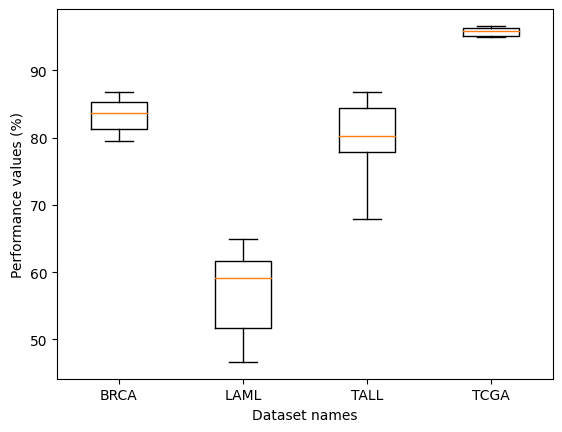

In [10]:
my_dict5 = {'BRCA': [80.9756, 83.9024, 82.43902, 85.8536, 85.3658, 79.5121, 86.8292, 85.3658, 83.4146, 79.5121], 
            'LAML': [51.6666, 46.6666, 61.6666, 50.0, 61.6666, 61.6666, 65.0, 65.0, 51.6666, 56.6666],
            'TALL': [86.7924, 81.13207, 77.358, 86.7924, 79.245, 79.245, 67.9245, 84.9056, 71.698, 83.0188],
            'TCGA': [95.169, 95.12077, 95.8454, 95.8937, 94.9275, 96.618, 96.3285, 96.4251, 95.169, 96.0869]
}

fig, ax = plt.subplots()
ax.boxplot(my_dict5.values())
ax.set_xticklabels(my_dict5.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

### B.2 Auto-Encoders ###

In [13]:
acc_AE_BRCA, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y6 = torch.Tensor(lblbin.fit_transform(labelsBRCA))
    X_train6, X_test6, Y_train6, Y_test6 = train_test_split(torch.Tensor(tpm_dataBRCA.T), torch.Tensor(Y6),test_size=0.2)
    insize6 = X_train6.shape[1]
    mmAE6, _, _, _, ac6 = engines.train_auto_encoder(insize6, 125, X_train6, X_test6, nepochs = 1000, printstep = 1000, lr = 5 * 1e-4)
    acc_AE_BRCA.append(round(ac6[-1], 4))
    #stats.pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy())[0]

Loss 0 Train - loss : 0.15 - acc : 0.008 Test acc : 0.008
Loss 999 Train - loss : 0.026 - acc : 0.665 Test acc : 0.657
Loss 0 Train - loss : 0.151 - acc : -0.005 Test acc : -0.005
Loss 999 Train - loss : 0.026 - acc : 0.664 Test acc : 0.66
Loss 0 Train - loss : 0.152 - acc : -0.005 Test acc : -0.005
Loss 999 Train - loss : 0.026 - acc : 0.664 Test acc : 0.659
Loss 0 Train - loss : 0.151 - acc : 0.003 Test acc : 0.003
Loss 999 Train - loss : 0.026 - acc : 0.665 Test acc : 0.656
Loss 0 Train - loss : 0.151 - acc : -0.003 Test acc : -0.003
Loss 999 Train - loss : 0.026 - acc : 0.663 Test acc : 0.663
Loss 0 Train - loss : 0.15 - acc : -0.008 Test acc : -0.009
Loss 999 Train - loss : 0.026 - acc : 0.666 Test acc : 0.652
Loss 0 Train - loss : 0.151 - acc : -0.004 Test acc : -0.005
Loss 999 Train - loss : 0.026 - acc : 0.664 Test acc : 0.661
Loss 0 Train - loss : 0.151 - acc : 0.004 Test acc : 0.004
Loss 999 Train - loss : 0.026 - acc : 0.663 Test acc : 0.664
Loss 0 Train - loss : 0.151 - acc

In [15]:
print(acc_AE_BRCA)

[0.6569, 0.6604, 0.6593, 0.6561, 0.6628, 0.6521, 0.6606, 0.6638, 0.6569, 0.6654]


In [16]:
acc_AE_LAML, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y7 = torch.Tensor(lblbin.fit_transform(labelsLAML))
    X_train7, X_test7, Y_train7, Y_test7 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(Y7),test_size=0.2)
    insize7 = X_train7.shape[1]
    mmAE7, _, _, _, ac7 = engines.train_auto_encoder(insize7, 125, X_train7, X_test7, nepochs = 1000, printstep = 1000, lr = 5 * 1e-4)
    acc_AE_LAML.append(round(ac7[-1], 4))

Loss 0 Train - loss : 1.188 - acc : -0.003 Test acc : -0.003
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.96
Loss 0 Train - loss : 1.197 - acc : -0.003 Test acc : -0.003
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958
Loss 0 Train - loss : 1.187 - acc : 0.0 Test acc : 0.0
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.96
Loss 0 Train - loss : 1.196 - acc : 0.005 Test acc : 0.004
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.959
Loss 0 Train - loss : 1.19 - acc : -0.004 Test acc : -0.005
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.958
Loss 0 Train - loss : 1.193 - acc : -0.002 Test acc : -0.002
Loss 999 Train - loss : 0.045 - acc : 0.959 Test acc : 0.96
Loss 0 Train - loss : 1.19 - acc : 0.002 Test acc : 0.002
Loss 999 Train - loss : 0.045 - acc : 0.96 Test acc : 0.96
Loss 0 Train - loss : 1.196 - acc : -0.003 Test acc : -0.003
Loss 999 Train - loss : 0.046 - acc : 0.959 Test acc : 0.962
Loss 0 Train - loss : 1.186 - acc : 0.005 Test

In [17]:
print(acc_AE_LAML)

[0.9595, 0.9585, 0.9596, 0.959, 0.9584, 0.9602, 0.9595, 0.9615, 0.9598, 0.9582]


In [18]:
acc_AE_TALL, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y8 = torch.Tensor(lblbin.fit_transform(labelsTALL))
    X_train8, X_test8, Y_train8, Y_test8 = train_test_split(torch.Tensor(tpm_dataTALL.T), torch.Tensor(Y8),test_size=0.2)
    insize8 = X_train8.shape[1]
    mmAE8, _, _, _, ac8 = engines.train_auto_encoder(insize8, 125, X_train8, X_test8, nepochs = 1000, printstep = 1000, lr = 5 * 1e-4)
    acc_AE_TALL.append(round(ac8[-1], 4))

Loss 0 Train - loss : 1.837 - acc : -0.008 Test acc : -0.008
Loss 999 Train - loss : 0.073 - acc : 0.969 Test acc : 0.969
Loss 0 Train - loss : 1.847 - acc : -0.006 Test acc : -0.006
Loss 999 Train - loss : 0.074 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.841 - acc : -0.005 Test acc : -0.005
Loss 999 Train - loss : 0.072 - acc : 0.97 Test acc : 0.968
Loss 0 Train - loss : 1.837 - acc : -0.0 Test acc : -0.001
Loss 999 Train - loss : 0.074 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.834 - acc : 0.002 Test acc : 0.002
Loss 999 Train - loss : 0.073 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.834 - acc : 0.007 Test acc : 0.007
Loss 999 Train - loss : 0.073 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.836 - acc : 0.006 Test acc : 0.006
Loss 999 Train - loss : 0.073 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.831 - acc : -0.004 Test acc : -0.004
Loss 999 Train - loss : 0.074 - acc : 0.969 Test acc : 0.97
Loss 0 Train - loss : 1.831 - acc : -0.

In [19]:
print(acc_AE_TALL)

[0.9695, 0.97, 0.9679, 0.9697, 0.9703, 0.9702, 0.9696, 0.9703, 0.9681, 0.9684]


In [20]:
acc_AE_TCGA, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Y9 = torch.Tensor(lblbin.fit_transform(labelsTCGA))
    X_train9, X_test9, Y_train9, Y_test9 = train_test_split(torch.Tensor(tpm_dataTCGA.T), torch.Tensor(Y9),test_size=0.2)
    insize9 = X_train9.shape[1]
    mmAE9, _, _, _, ac9 = engines.train_auto_encoder(insize9, 125, X_train9, X_test9, nepochs = 1000, printstep = 1000, lr = 5 * 1e-4)
    acc_AE_TCGA.append(round(ac9[-1], 4))

Loss 0 Train - loss : 0.972 - acc : -0.004 Test acc : -0.004
Loss 999 Train - loss : 0.135 - acc : 0.853 Test acc : 0.853
Loss 0 Train - loss : 0.971 - acc : 0.004 Test acc : 0.004
Loss 999 Train - loss : 0.104 - acc : 0.888 Test acc : 0.887
Loss 0 Train - loss : 0.971 - acc : -0.008 Test acc : -0.008
Loss 999 Train - loss : 0.104 - acc : 0.887 Test acc : 0.885
Loss 0 Train - loss : 0.973 - acc : 0.008 Test acc : 0.008
Loss 999 Train - loss : 0.133 - acc : 0.853 Test acc : 0.854
Loss 0 Train - loss : 0.972 - acc : -0.009 Test acc : -0.009
Loss 999 Train - loss : 0.134 - acc : 0.854 Test acc : 0.853
Loss 0 Train - loss : 0.972 - acc : -0.004 Test acc : -0.004
Loss 999 Train - loss : 0.104 - acc : 0.887 Test acc : 0.885
Loss 0 Train - loss : 0.972 - acc : 0.007 Test acc : 0.007
Loss 999 Train - loss : 0.106 - acc : 0.885 Test acc : 0.887
Loss 0 Train - loss : 0.973 - acc : -0.007 Test acc : -0.007
Loss 999 Train - loss : 0.105 - acc : 0.887 Test acc : 0.886
Loss 0 Train - loss : 0.971 - 

In [21]:
print(acc_AE_TCGA)

[0.8532, 0.8868, 0.8848, 0.8536, 0.8527, 0.8854, 0.887, 0.8863, 0.8864, 0.8875]


Text(0, 0.5, 'Performance values (%)')

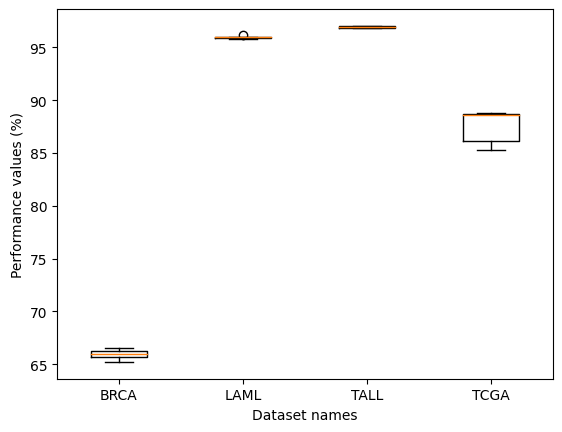

In [29]:
my_dict6 = {'BRCA': [65.69, 66.04, 65.93, 65.61, 66.28, 65.21, 66.06, 66.38, 65.69, 66.54], 
           'LAML': [95.95, 95.85, 95.96, 95.9, 95.84, 96.02, 95.95, 96.15, 95.98, 95.82],
           'TALL': [96.95, 97.0, 96.79, 96.97, 97.03, 97.02, 96.96, 97.03, 96.81, 96.84],
           'TCGA': [85.32, 88.68, 88.48, 85.36, 85.27, 88.54, 88.7, 88.63, 88.64, 88.75]
}

fig, ax = plt.subplots()
ax.boxplot(my_dict6.values())
ax.set_xticklabels(my_dict6.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

### B.3 VAE ###

In [42]:
acc_VAE_BRCA, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Yv1 = torch.Tensor(lblbin.fit_transform(labelsBRCA))
    X_trainv1, X_testv1, Y_trainv1, Y_testv1 = train_test_split(torch.Tensor(tpm_dataBRCA.T), torch.Tensor(Yv1),test_size=0.2)
    insizev1 = X_trainv1.shape[1] 
    mmVAE1, _, _, _, acc1 = engines.train_variational_auto_encoder(insizev1, 125, X_trainv1, X_testv1, nepochs = 1000, printstep=1000)
    acc_VAE_BRCA.append(round(acc1[-1], 4))
    

Loss 0 Train - loss : 0.23 - acc : -0.003 Test acc : -0.004
Loss 999 Train - loss : 0.023 - acc : 0.705 Test acc : 0.71
Loss 0 Train - loss : 0.24 - acc : 0.0 Test acc : 0.001
Loss 999 Train - loss : 0.023 - acc : 0.706 Test acc : 0.704
Loss 0 Train - loss : 0.263 - acc : -0.011 Test acc : -0.011
Loss 999 Train - loss : 0.023 - acc : 0.707 Test acc : 0.698
Loss 0 Train - loss : 0.234 - acc : -0.002 Test acc : -0.002
Loss 999 Train - loss : 0.023 - acc : 0.706 Test acc : 0.703
Loss 0 Train - loss : 0.262 - acc : -0.002 Test acc : -0.003
Loss 999 Train - loss : 0.023 - acc : 0.704 Test acc : 0.712
Loss 0 Train - loss : 0.234 - acc : 0.004 Test acc : 0.004
Loss 999 Train - loss : 0.023 - acc : 0.706 Test acc : 0.703
Loss 0 Train - loss : 0.211 - acc : 0.005 Test acc : 0.006
Loss 999 Train - loss : 0.023 - acc : 0.707 Test acc : 0.699
Loss 0 Train - loss : 0.228 - acc : -0.002 Test acc : -0.003
Loss 999 Train - loss : 0.023 - acc : 0.706 Test acc : 0.713
Loss 0 Train - loss : 0.216 - acc :

In [43]:
print(acc_VAE_BRCA)

[0.7097, 0.7043, 0.6985, 0.7028, 0.7117, 0.7027, 0.6994, 0.7128, 0.7065, 0.7007]


In [44]:
acc_VAE_LAML, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Yv2 = torch.Tensor(lblbin.fit_transform(labelsLAML))
    X_trainv2, X_testv2, Y_trainv2, Y_testv2 = train_test_split(torch.Tensor(tpm_dataLAML.T), torch.Tensor(Yv2),test_size=0.2)
    insizev2 = X_trainv2.shape[1] 
    mmVAE2, _, _, _, acc2 = engines.train_variational_auto_encoder(insizev2, 125, X_trainv2, X_testv2, nepochs = 1000, printstep=1000)
    acc_VAE_LAML.append(round(acc2[-1], 4))
    

Loss 0 Train - loss : 1.293 - acc : -0.002 Test acc : -0.001
Loss 999 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 0 Train - loss : 1.263 - acc : -0.005 Test acc : -0.005
Loss 999 Train - loss : 0.037 - acc : 0.966 Test acc : 0.967
Loss 0 Train - loss : 1.297 - acc : 0.005 Test acc : 0.004
Loss 999 Train - loss : 0.038 - acc : 0.966 Test acc : 0.965
Loss 0 Train - loss : 1.278 - acc : 0.008 Test acc : 0.008
Loss 999 Train - loss : 0.036 - acc : 0.968 Test acc : 0.962
Loss 0 Train - loss : 1.264 - acc : -0.001 Test acc : -0.001
Loss 999 Train - loss : 0.038 - acc : 0.966 Test acc : 0.966
Loss 0 Train - loss : 1.256 - acc : 0.003 Test acc : 0.003
Loss 999 Train - loss : 0.038 - acc : 0.966 Test acc : 0.967
Loss 0 Train - loss : 1.254 - acc : -0.0 Test acc : -0.0
Loss 999 Train - loss : 0.039 - acc : 0.966 Test acc : 0.967
Loss 0 Train - loss : 1.297 - acc : 0.009 Test acc : 0.008
Loss 999 Train - loss : 0.037 - acc : 0.967 Test acc : 0.965
Loss 0 Train - loss : 1.303 - acc : 

In [45]:
print(acc_VAE_LAML)

[0.9674, 0.9671, 0.9649, 0.9622, 0.9657, 0.9667, 0.967, 0.9648, 0.9677, 0.9658]


In [47]:
acc_VAE_TALL, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Yv3 = torch.Tensor(lblbin.fit_transform(labelsTALL))
    X_trainv3, X_testv3, Y_trainv3, Y_testv3 = train_test_split(torch.Tensor(tpm_dataTALL.T), torch.Tensor(Yv3),test_size=0.2)
    insizev3 = X_trainv3.shape[1] 
    mmVAE3, _, _, _, acc3 = engines.train_variational_auto_encoder(insizev3, 125, X_trainv3, X_testv3, nepochs = 1000, printstep=1000)
    acc_VAE_TALL.append(round(acc3[-1], 4))
    

Loss 0 Train - loss : 1.882 - acc : 0.001 Test acc : 0.001
Loss 999 Train - loss : 0.066 - acc : 0.972 Test acc : 0.972
Loss 0 Train - loss : 1.944 - acc : 0.001 Test acc : 0.002
Loss 999 Train - loss : 0.065 - acc : 0.973 Test acc : 0.971
Loss 0 Train - loss : 1.985 - acc : 0.004 Test acc : 0.005
Loss 999 Train - loss : 0.065 - acc : 0.973 Test acc : 0.972
Loss 0 Train - loss : 1.91 - acc : -0.003 Test acc : -0.002
Loss 999 Train - loss : 0.065 - acc : 0.973 Test acc : 0.971
Loss 0 Train - loss : 1.919 - acc : -0.001 Test acc : -0.001
Loss 999 Train - loss : 0.066 - acc : 0.972 Test acc : 0.972
Loss 0 Train - loss : 1.969 - acc : -0.001 Test acc : -0.001
Loss 999 Train - loss : 0.065 - acc : 0.972 Test acc : 0.972
Loss 0 Train - loss : 1.896 - acc : 0.005 Test acc : 0.005
Loss 999 Train - loss : 0.066 - acc : 0.972 Test acc : 0.973
Loss 0 Train - loss : 1.916 - acc : -0.004 Test acc : -0.004
Loss 999 Train - loss : 0.065 - acc : 0.973 Test acc : 0.971
Loss 0 Train - loss : 1.947 - acc

In [48]:
print(acc_VAE_TALL)

[0.9721, 0.971, 0.9719, 0.9712, 0.9718, 0.9716, 0.973, 0.9709, 0.9714, 0.9706]


In [49]:
acc_VAE_TCGA, n_rep = [], 10
for i in range(n_rep):
    lblbin = LabelBinarizer()
    Yv4 = torch.Tensor(lblbin.fit_transform(labelsTCGA))
    X_trainv4, X_testv4, Y_trainv4, Y_testv4 = train_test_split(torch.Tensor(tpm_dataTCGA.T), torch.Tensor(Yv4),test_size=0.2)
    insizev4 = X_trainv4.shape[1] 
    mmVAE4, _, _, _, acc4 = engines.train_variational_auto_encoder(insizev4, 125, X_trainv4, X_testv4, nepochs = 1000, printstep=1000)
    acc_VAE_TCGA.append(round(acc4[-1], 4))
    

Loss 0 Train - loss : 1.05 - acc : 0.002 Test acc : 0.002
Loss 999 Train - loss : 0.105 - acc : 0.886 Test acc : 0.885
Loss 0 Train - loss : 1.079 - acc : 0.005 Test acc : 0.005
Loss 999 Train - loss : 0.108 - acc : 0.882 Test acc : 0.882
Loss 0 Train - loss : 1.042 - acc : 0.001 Test acc : 0.0
Loss 999 Train - loss : 0.106 - acc : 0.885 Test acc : 0.883
Loss 0 Train - loss : 1.071 - acc : 0.001 Test acc : 0.001
Loss 999 Train - loss : 0.106 - acc : 0.885 Test acc : 0.884
Loss 0 Train - loss : 1.082 - acc : 0.001 Test acc : 0.001
Loss 999 Train - loss : 0.107 - acc : 0.883 Test acc : 0.881
Loss 0 Train - loss : 1.066 - acc : -0.005 Test acc : -0.005
Loss 999 Train - loss : 0.106 - acc : 0.885 Test acc : 0.884
Loss 0 Train - loss : 1.05 - acc : 0.001 Test acc : 0.001
Loss 999 Train - loss : 0.106 - acc : 0.885 Test acc : 0.885
Loss 0 Train - loss : 1.084 - acc : -0.003 Test acc : -0.003
Loss 999 Train - loss : 0.107 - acc : 0.884 Test acc : 0.883
Loss 0 Train - loss : 1.053 - acc : -0.0

In [50]:
print(acc_VAE_TCGA)

[0.8848, 0.882, 0.883, 0.8839, 0.8814, 0.884, 0.8852, 0.8828, 0.8855, 0.8836]


Text(0, 0.5, 'Performance values (%)')

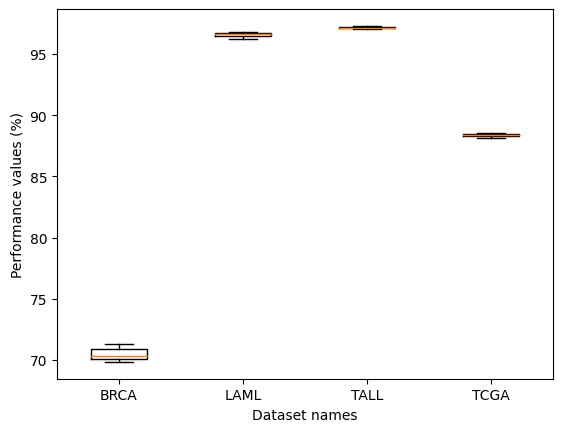

In [51]:
my_dict7 = {'BRCA': [70.97, 70.43, 69.85, 70.28, 71.17, 70.27, 69.94, 71.28, 70.65, 70.07], 
           'LAML': [96.74, 96.71, 96.49, 96.22, 96.57, 96.67, 96.7, 96.48, 96.77, 96.58],
           'TALL': [97.21, 97.1, 97.19, 97.12, 97.18, 97.16, 97.3, 97.09, 97.14, 97.06],
           'TCGA': [88.48, 88.2, 88.3, 88.39, 88.14, 88.4, 88.52, 88.28, 88.55, 88.36]
}

fig, ax = plt.subplots()
ax.boxplot(my_dict7.values())
ax.set_xticklabels(my_dict7.keys())
ax.set_xlabel('Dataset names')
ax.set_ylabel('Performance values (%)')

### SYNTHESE BRCA DATA ###

SVM :  81.95 +/- 1.3803
RidgeC :  78.684 +/- 3.0223
DNNLin :  83.317 +/- 2.5045
RandF :  81.0721 +/- 2.1787
DNN :  81.9999 +/- 2.7805
AE :  65.943 +/- 0.3822
VAE :  70.491 +/- 0.4824


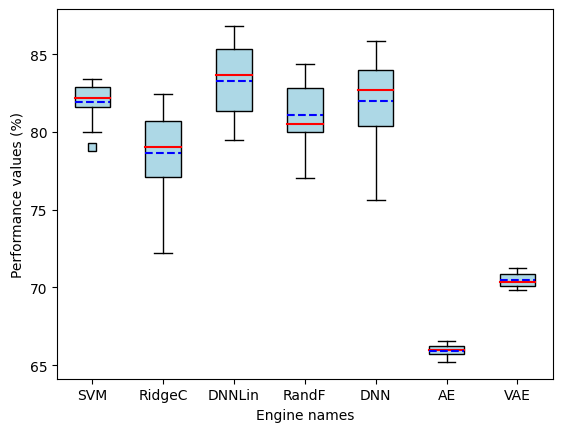

In [53]:
my_dict8 = {'SVM': [82.93, 82.44, 83.41, 80.0, 81.46, 79.02, 83.41, 81.95, 82.93, 81.95],
            'RidgeC': [80.0, 79.02, 76.59, 82.44, 79.02, 72.2, 75.61, 82.44, 80.97999, 78.539999],
            'DNNLin': [80.9756, 83.9024, 82.43902, 85.8536, 85.3658, 79.5121, 86.8292, 85.3658, 83.4146, 79.5121],
            'RandF': [80.0, 83.89, 77.071, 80.49, 80.0, 79.02, 80.49, 82.44, 82.93, 84.39],
            'DNN': [82.9268, 84.3902, 85.8536, 81.463, 80.0, 75.6097, 82.439, 82.9268, 80.0, 84.39],
            'AE': [65.69, 66.04, 65.93, 65.61, 66.28, 65.21, 66.06, 66.38, 65.69, 66.54],
            'VAE': [70.97, 70.43, 69.85, 70.28, 71.17, 70.27, 69.94, 71.28, 70.65, 70.07]
}

fig, ax = plt.subplots()
ax.boxplot(my_dict8.values(), patch_artist=True, showmeans = True, meanline = True,
           medianprops = dict(color = "red", linewidth = 1.5), boxprops = dict(facecolor = "lightblue"),
           meanprops = dict(color = "blue", linewidth = 1.5), showfliers = True, 
           flierprops = dict(marker = "s", markerfacecolor = "lightblue")) 
ax.set_xticklabels(my_dict8.keys())
ax.set_xlabel('Engine names')
ax.set_ylabel('Performance values (%)')
fig.savefig("BRCAboxplots.pdf")
print('SVM : ', round(np.mean(my_dict8['SVM']), 4), '+/-', round(np.std(my_dict8['SVM']), 4))
print('RidgeC : ', round(np.mean(my_dict8['RidgeC']), 4), '+/-', round(np.std(my_dict8['RidgeC']), 4))
print('DNNLin : ', round(np.mean(my_dict8['DNNLin']), 4), '+/-', round(np.std(my_dict8['DNNLin']), 4))
print('RandF : ', round(np.mean(my_dict8['RandF']), 4), '+/-', round(np.std(my_dict8['RandF']), 4))
print('DNN : ', round(np.mean(my_dict8['DNN']), 4), '+/-', round(np.std(my_dict8['DNN']), 4))
print('AE : ', round(np.mean(my_dict8['AE']), 4), '+/-', round(np.std(my_dict8['AE']), 4))
print('VAE : ', round(np.mean(my_dict8['VAE']), 4), '+/-', round(np.std(my_dict8['VAE']), 4))

### SYNTHESE LAML DATA ###

SVM :  62.333 +/- 6.109
RidgeC :  58.5012 +/- 6.6831
DNNLin :  57.1666 +/- 6.3705
RandF :  61.5 +/- 5.2413
DNN :  58.6659 +/- 5.6661
AE :  95.942 +/- 0.0931
VAE :  96.593 +/- 0.1572


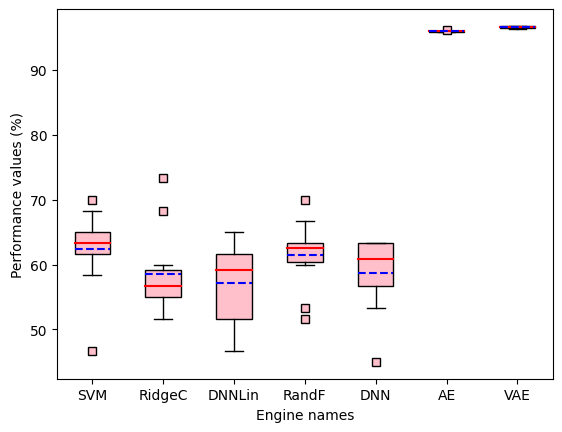

In [54]:
my_dict9 = {'SVM': [65.0, 61.67, 65.0, 63.33, 70.0, 61.67, 68.33, 58.33, 46.67, 63.33],
            'RidgeC': [56.67, 55.001, 56.67, 55.001, 51.67, 56.67, 51.67, 68.33, 60.0, 73.33],
            'DNNLin': [51.6666, 46.6666, 61.6666, 50.0, 61.6666, 61.6666, 65.0, 65.0, 51.6666, 56.6666],
            'RandF': [63.33, 63.33, 66.67, 60.0, 70.0, 63.33, 51.67, 61.67, 61.67, 53.33],
            'DNN': [56.6667, 60.0, 61.667, 56.6667, 53.333, 45.0, 63.333, 63.333, 63.33, 63.33],
            'AE': [95.95, 95.85, 95.96, 95.9, 95.84, 96.02, 95.95, 96.15, 95.98, 95.82],
            'VAE': [96.74, 96.71, 96.49, 96.22, 96.57, 96.67, 96.7, 96.48, 96.77, 96.58]        
}

fig, ax = plt.subplots()
ax.boxplot(my_dict9.values(), patch_artist=True, showmeans = True, meanline = True, 
           medianprops = dict(color = "red", linewidth = 1.5), boxprops = dict(facecolor = "pink"),
           meanprops = dict(color = "blue", linewidth = 1.5), showfliers = True,
          flierprops = dict(marker = "s", markerfacecolor = "pink"))
ax.set_xticklabels(my_dict9.keys())
ax.set_xlabel('Engine names')
ax.set_ylabel('Performance values (%)')
fig.savefig("LAMLboxplots.pdf")
print('SVM : ', round(np.mean(my_dict9['SVM']), 4), '+/-', round(np.std(my_dict9['SVM']), 4))
print('RidgeC : ', round(np.mean(my_dict9['RidgeC']), 4), '+/-', round(np.std(my_dict9['RidgeC']), 4))
print('DNNLin : ', round(np.mean(my_dict9['DNNLin']), 4), '+/-', round(np.std(my_dict9['DNNLin']), 4))
print('RandF : ', round(np.mean(my_dict9['RandF']), 4), '+/-', round(np.std(my_dict9['RandF']), 4))
print('DNN : ', round(np.mean(my_dict9['DNN']), 4), '+/-', round(np.std(my_dict9['DNN']), 4))
print('AE : ', round(np.mean(my_dict9['AE']), 4), '+/-', round(np.std(my_dict9['AE']), 4))
print('VAE : ', round(np.mean(my_dict9['VAE']), 4), '+/-', round(np.std(my_dict9['VAE']), 4))

### SYNTHESE TALL DATA ###

SVM :  80.756 +/- 3.5601
RidgeC :  84.152 +/- 3.6981
DNNLin :  79.8112 +/- 5.9096
RandF :  77.737 +/- 5.3235
DNN :  76.4151 +/- 5.6761
AE :  96.94 +/- 0.0877
VAE :  97.155 +/- 0.0661


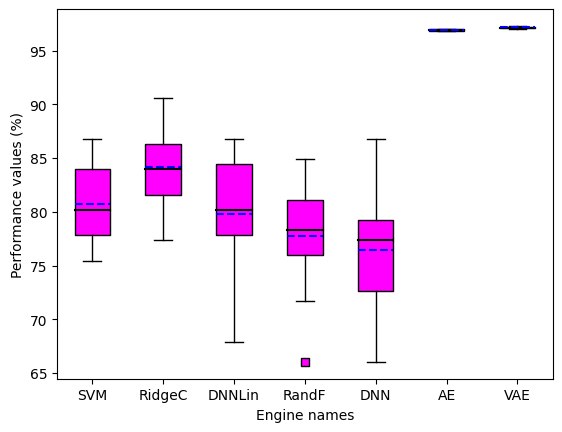

In [55]:
my_dict10 = {'SVM': [84.91, 79.25, 79.25, 77.36, 81.13, 86.79, 77.36, 81.13, 75.47, 84.91],
             'RidgeC': [84.91, 77.36, 83.0201, 90.57, 88.68, 81.13, 81.13, 86.79, 84.91, 83.02001],
             'DNNLin': [86.7924, 81.13207, 77.358, 86.7924, 79.245, 79.245, 67.9245, 84.9056, 71.698, 83.0188],
             'RandF': [83.021, 77.36, 84.91, 77.36, 66.039, 79.25, 81.13, 71.7, 81.13, 75.47],
             'DNN': [71.698, 77.35849, 77.35849, 66.0377, 79.24528, 81.132, 75.4716, 69.8113, 79.24528, 86.79245],
             'AE': [96.95, 97.0, 96.79, 96.97, 97.03, 97.02, 96.96, 97.03, 96.81, 96.84],
             'VAE': [97.21, 97.1, 97.19, 97.12, 97.18, 97.16, 97.3, 97.09, 97.14, 97.06]      
}

fig, ax = plt.subplots()
ax.boxplot(my_dict10.values(), patch_artist=True, showmeans = True, meanline = True, 
           medianprops = dict(color = "black", linewidth = 1.5), boxprops = dict(facecolor = "magenta"),
           meanprops = dict(color = "blue", linewidth = 1.5), showfliers = True,
          flierprops = dict(marker = "s", markerfacecolor = "magenta"))
ax.set_xticklabels(my_dict10.keys())
ax.set_xlabel('Engine names')
ax.set_ylabel('Performance values (%)')
fig.savefig("TALLboxplots.pdf")
print('SVM : ', round(np.mean(my_dict10['SVM']), 4), '+/-', round(np.std(my_dict10['SVM']), 4))
print('RidgeC : ', round(np.mean(my_dict10['RidgeC']), 4), '+/-', round(np.std(my_dict10['RidgeC']), 4))
print('DNNLin : ', round(np.mean(my_dict10['DNNLin']), 4), '+/-', round(np.std(my_dict10['DNNLin']), 4))
print('RandF : ', round(np.mean(my_dict10['RandF']), 4), '+/-', round(np.std(my_dict10['RandF']), 4))
print('DNN : ', round(np.mean(my_dict10['DNN']), 4), '+/-', round(np.std(my_dict10['DNN']), 4))
print('AE : ', round(np.mean(my_dict10['AE']), 4), '+/-', round(np.std(my_dict10['AE']), 4))
print('VAE : ', round(np.mean(my_dict10['VAE']), 4), '+/-', round(np.std(my_dict10['VAE']), 4))

### SYNTHESE TCGA DATA ###

SVM :  96.909 +/- 0.237
RidgeC :  96.631 +/- 0.3381
DNNLin :  95.7584 +/- 0.586
RandF :  93.691 +/- 0.4953
DNN :  95.6906 +/- 0.4835
AE :  87.637 +/- 1.5209
VAE :  88.362 +/- 0.1275


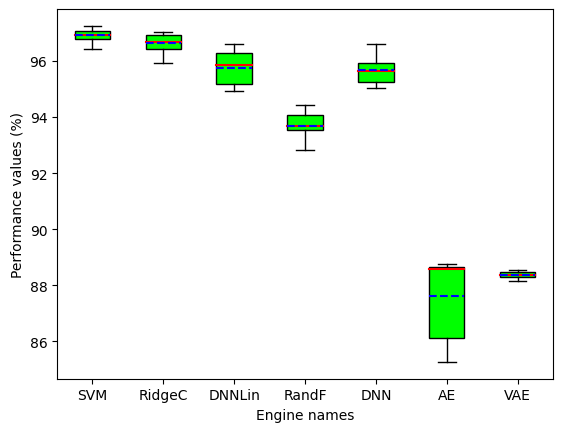

In [56]:
my_dict11 = {'SVM': [97.1, 96.76, 97.2, 96.86, 96.67, 96.96, 97.0, 96.86, 97.25, 96.43],
             'RidgeC': [97.05, 96.52, 95.94, 96.71, 97.0, 97.05, 96.33, 96.71, 96.6199, 96.38],
             'DNNLin': [95.169, 95.12077, 95.8454, 95.8937, 94.9275, 96.618, 96.3285, 96.4251, 95.169, 96.0869],
             'RandF': [93.62, 92.81, 92.9, 93.53, 93.72, 94.44, 93.67, 93.96, 94.11, 94.15],
             'DNN': [96.618, 95.217, 95.652, 96.280, 95.942, 95.217, 95.652, 95.942, 95.362, 95.024],
             'AE': [85.32, 88.68, 88.48, 85.36, 85.27, 88.54, 88.7, 88.63, 88.64, 88.75],
             'VAE': [88.48, 88.2, 88.3, 88.39, 88.14, 88.4, 88.52, 88.28, 88.55, 88.36]          
}

fig, ax = plt.subplots()
ax.boxplot(my_dict11.values(), patch_artist=True, showmeans = True, meanline = True, 
           medianprops = dict(color = "red", linewidth = 1.5), boxprops = dict(facecolor = "lime"),
           meanprops = dict(color = "blue", linewidth = 1.5), showfliers = True,
          flierprops = dict(marker = "s", markerfacecolor = "lime"))
ax.set_xticklabels(my_dict11.keys())
ax.set_xlabel('Engine names')
ax.set_ylabel('Performance values (%)')
fig.savefig("TCGAboxplots.pdf")
print('SVM : ', round(np.mean(my_dict11['SVM']), 4), '+/-', round(np.std(my_dict11['SVM']), 4))
print('RidgeC : ', round(np.mean(my_dict11['RidgeC']), 4), '+/-', round(np.std(my_dict11['RidgeC']), 4))
print('DNNLin : ', round(np.mean(my_dict11['DNNLin']), 4), '+/-', round(np.std(my_dict11['DNNLin']), 4))
print('RandF : ', round(np.mean(my_dict11['RandF']), 4), '+/-', round(np.std(my_dict11['RandF']), 4))
print('DNN : ', round(np.mean(my_dict11['DNN']), 4), '+/-', round(np.std(my_dict11['DNN']), 4))
print('AE : ', round(np.mean(my_dict11['AE']), 4), '+/-', round(np.std(my_dict11['AE']), 4))
print('VAE : ', round(np.mean(my_dict11['VAE']), 4), '+/-', round(np.std(my_dict11['VAE']), 4))